# Part 6 / ICE Analysis

ICE (Individual Conditional Expectation) Analysis
Question 6 - Part 1: Local interpretability analysis

This notebook implements ICE plots with PDP overlay for the top features
of the XGBoost credit scoring model.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import string


In [ ]:
def get_features(df: pd.DataFrame()) -> pd.DataFrame():
    """Get additional features - matching model training preprocessing."""
    df_with_features = (
        df
        .assign(
            # Only revol_bal_log (not other logs)
            revol_bal_log = np.log1p(df["revol_bal"]),

            # total balance
            cur_balance = df["avg_cur_bal"] * df["open_acc"],

            # flags
            delinq_2yrs_flag = df["delinq_2yrs"] >= 1,
            tax_liens_flag = df["tax_liens"] >= 1,

            # shares
            s_actv_bc_tl = df["num_actv_bc_tl"] / (df["open_acc"] + 1e-6),
            s_bc_tl = df["num_bc_tl"] / (df["open_acc"] + 1e-6),
            s_il_tl = df["num_il_tl"] / (df["open_acc"] + 1e-6),
            s_rev_accts = df["num_rev_accts"] / (df["open_acc"] + 1e-6),

            # interactions
            revol_bal_income_ratio = df["revol_bal"] / (df["annual_inc"] + 1e-6),
        )
    )
    return df_with_features


In [ ]:
def categorical_encoding(df: pd.DataFrame) -> pd.DataFrame:
    """Encodings of categorical variables - matching model training preprocessing."""
    df_encoded = df.copy()

    # sub_grade to numeric
    sg = df_encoded["sub_grade"].astype(str).str.upper().str.strip()
    letter = sg.str[0]
    number = pd.to_numeric(sg.str[1:].str.extract(r"(\d+)", expand=False), errors="coerce")
    letter_map = {ch: i+1 for i, ch in enumerate("ABCDEFG")}
    base = letter.map(letter_map)
    sub_grade_num = (base - 1) * 5 + number
    df_encoded["sub_grade_num"] = sub_grade_num.astype("float32")

    # emp_length to numeric
    emp_length_map = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
        '10+ years': 10
    }
    df_encoded["emp_length_num"] = df_encoded["emp_length"].map(emp_length_map).astype("float32")

    # zip_risk encoding (instead of zip_code2)
    # Create zip_risk categories based on zip_code
    df_encoded["zip_risk"] = pd.cut(df_encoded["zip_code"], 
                                   bins=[0, 20000, 40000, 60000, 100000], 
                                   labels=["Low", "Low-Med", "Medium", "Med-High"])
    df_encoded = pd.get_dummies(df_encoded, columns=["zip_risk"], prefix="zip_risk")

    # one-hot for home_ownership and purpose
    onehot_cols = ["home_ownership", "purpose"]
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True)

    # emp_title with grouped prefix (matching model)
    df_encoded = pd.get_dummies(df_encoded, columns=["emp_title"], prefix="emp_title_grouped", drop_first=True)

    # drop originals and unused columns
    df_encoded = df_encoded.drop(columns=["grade", "sub_grade", "emp_length", "issue_d", "revol_bal", "zip_code", "Pct_afro_american"])

    return df_encoded


In [ ]:
# Load the model
xgb_model = joblib.load('optimized_xgb_model.pkl')

# Load and prepare data
df = pd.read_csv("dataproject2025.csv", index_col=0)
df.drop(columns=['Predictions', 'Predicted probabilities'], inplace=True)
df_dropped = df.dropna(axis=0)

# Feature engineering
df_engineered = get_features(df_dropped)
df_encoded = categorical_encoding(df_engineered)

# Prepare features and target
target_col = 'target'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data loaded successfully!")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Number of features: {X.shape[1]}")


Data loaded successfully!
Training set size: (868988, 112)
Test set size: (217248, 112)


In [9]:
# Get feature names and importance
feature_names = X_train.columns
feature_importance = xgb_model.feature_importances_

# Choose top 4 features
top_idx = np.argsort(feature_importance)[-4:]
features_to_plot = [feature_names[i] for i in top_idx]

print("Top 4 features for ICE analysis:")
for i, feat in enumerate(features_to_plot):
    print(f"{i+1}. {feat}: {feature_importance[top_idx[i]]:.4f}")


Top 4 features for ICE analysis:
1. int_rate: 0.0679
2. int_rate_x_duration: 0.0723
3. sub_grade_num: 0.1117
4. grade_num: 0.2880


/home/alcyenna/myenv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 45 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


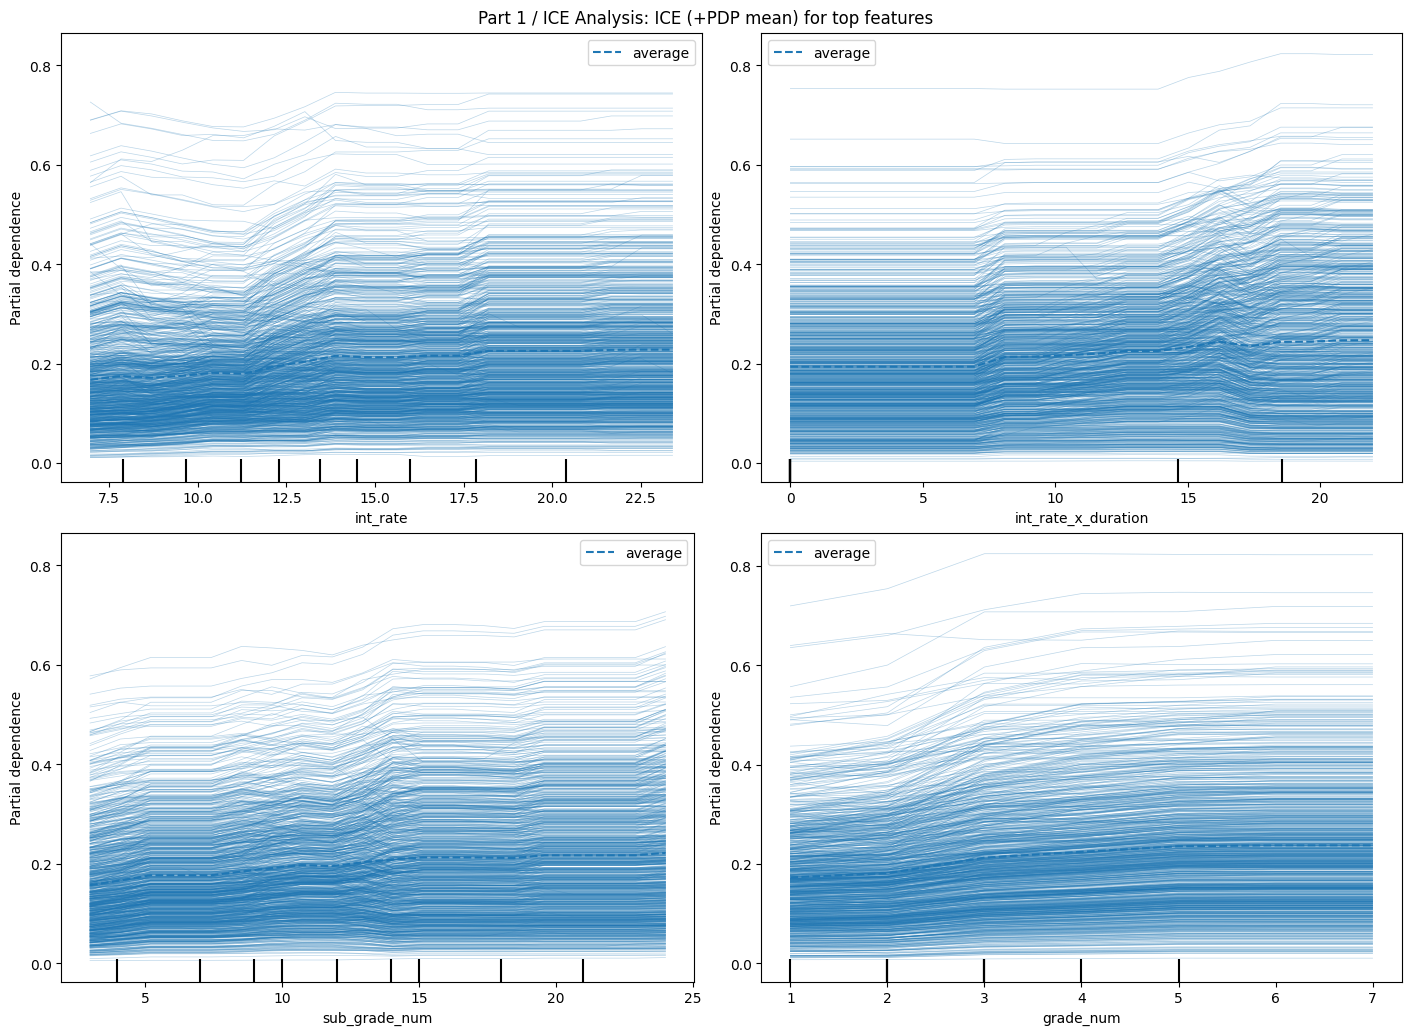

In [10]:
# ICE plots (subsample + PDP overlay)
# Subsample rows for speed
max_rows = 5000
X_ref = X_train.sample(n=max_rows, random_state=42) if len(X_train) > max_rows else X_train

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
axes = axes.ravel()

for ax, feat in zip(axes, features_to_plot):
    PartialDependenceDisplay.from_estimator(
        xgb_model,
        X_ref,
        features=[feat],
        kind='both',  # ICE + PDP mean
        ax=ax,
        feature_names=feature_names,
        grid_resolution=20,
    )
    ax.set_title(f"ICE + PDP — {feat}")

plt.suptitle('Part 1 / ICE Analysis: ICE (+PDP mean) for top features', y=1.02)
plt.show()
